In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import bootstrap, fit, norm, chisquare, goodness_of_fit, lognorm, t,beta, cosine, uniform, kstest, anderson, expon, gumbel_l, weibull_min, expon, logistic, gumbel_r
from scipy.optimize import curve_fit
from tqdm import tqdm
from os.path import basename, exists

# Creating the master dataframe

filepath='..\\Results\\final_results\\bllvsfsrq\\Model Validation\\'
init_df = pd.read_csv(filepath+'y_results_imputed_wrappered_12_run1.csv',index_col=0) # we just need this for the length
init_df=init_df.drop(init_df[init_df['y_test']==7].index)
print(init_df)
count = 0
n_bins=10
bin_size = int(len(init_df)/n_bins)



rdgprobs = pd.DataFrame()
allprobs = pd.DataFrame(np.array([np.zeros(len(init_df))]).T,columns=['CLASS'])
allprobs['sum']=np.zeros(len(allprobs))

# We want to add results from each iteration to a master dataframe

for i in range(1,11):
    df = pd.read_csv(filepath+'y_results_imputed_wrappered_12_run'+str(i)+'.csv')
    df=df.drop(df[df['y_test']==7].index)
    rdgprobs['iteration_' +str(i)] = df['y_proba_1'].loc[df['y_test']==3]
    allprobs['iteration_'+str(i)] = df['y_proba_1']
    allprobs['CLASS_it' +str(i) ] = df['y_test']


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download('https://github.com/AllenDowney/AstronomicalData/raw/main/' + 'az-paper-twocol.mplstyle')
plt.style.use('./az-paper-twocol.mplstyle')


     y_test  y_pred  y_proba_0  y_proba_1
0       0.0     0.0   0.909246   0.090754
1       0.0     0.0   0.988779   0.011221
2       1.0     1.0   0.131782   0.868218
3       0.0     1.0   0.231922   0.768078
4       1.0     1.0   0.046857   0.953143
..      ...     ...        ...        ...
741     3.0     0.0   0.964255   0.035745
742     3.0     0.0   0.536274   0.463726
743     3.0     1.0   0.487185   0.512815
744     3.0     0.0   0.714690   0.285310
745     3.0     1.0   0.267210   0.732790

[746 rows x 4 columns]


Freedman-Diaconis' Rule for histogram bin widths is implemented below

In [5]:
# extracting key features of the data e.g. interquartile range

IQR = np.zeros(10)
for i in range(1,11):
    IQR[i-1] = allprobs['iteration_'+str(i)].quantile(q=0.75)-allprobs['iteration_'+str(i)].quantile(q=0.25)

IQR_av = np.average(IQR)

# extracting the number of radio galaxies

n = len(rdgprobs)

# implementing freedman-diaconis

h = 2*IQR_av*(n**(-1/3))

print(h) 



0.398539448690048


Plotting a Histogram based on Freedman-Diaconis

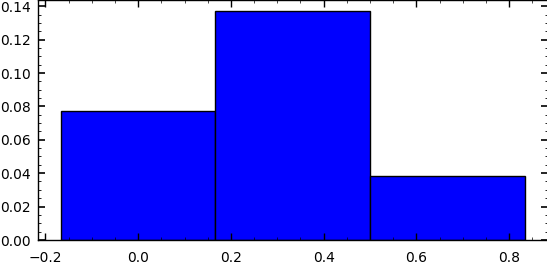

In [6]:
n_bins = int(np.ceil(1/h))

bin_width = 1/n_bins

# averaging columns

probs_asc = pd.DataFrame()

for i in range(1,2):
    probs_asc['it'+str(i)] = np.sort(np.array(allprobs['iteration_'+str(i)]))

probs_avgs = probs_asc.mean(axis=1)

# averaging radio galaxy probs (radio galaxies are always in the same order)
rdgprobs_avgs = np.array(rdgprobs.mean(axis=1))

# binning the data

freedman_bins = pd.DataFrame(np.array([np.arange(0,n_bins,1),np.zeros(n_bins),np.zeros(n_bins)]).T,columns=('bin','total count','rdg count'))

for i in range(0,n_bins):
    for k in range(0,len(allprobs)):
        if probs_avgs[k] >= bin_width*i and probs_avgs[k] < bin_width*(i+1):
            freedman_bins['total count'][i] +=1
    for k in range(0,len(rdgprobs_avgs)):
        if rdgprobs_avgs[k] >= bin_width*i and rdgprobs_avgs[k] < bin_width*(i+1):
            freedman_bins['rdg count'][i] +=1
        

freedman_bins['rdg frac'] = freedman_bins['rdg count']/freedman_bins['total count']
plt.bar(freedman_bins['bin']/n_bins,freedman_bins['rdg frac'],width = bin_width,edgecolor='black',color='blue')

freedman_bins['bin median'] = (bin_width * freedman_bins['bin']) + 0.5*bin_width

In [12]:

dist = gumbel_r
dist_='gumbel_r'



'''In order to create dummy data we must create data which is distributed across the bins in the same proportions
and yet has an overall sample size equal to the overall number of radio galaxies'''

def bin_rounding(xs,n_bins):
    bin_width = 1/n_bins
    bins = np.arange(0,n_bins,1)
    bin_medians = (bin_width*bins)+0.5*bin_width
    roundedxs = np.empty(len(xs))

    for i in range(0,n_bins):
        for k in range(0,len(xs)):
            if xs[k] >= bin_width*i and xs[k] < bin_width*(i+1):
                roundedxs[k] = bin_medians[i]

    return roundedxs


freedman_bins['adjusted rdg count'] = ((freedman_bins['rdg frac']/(freedman_bins['rdg frac'].sum()))*freedman_bins['rdg count'].sum()).round()
dummydata = np.array([])

for i in range(0,len(freedman_bins)):
    dummydata = np.append(dummydata,freedman_bins['bin median'][i]*np.ones(int(freedman_bins['adjusted rdg count'][i])))


''' in order to do a parametric bootstrap test we will generate values (monte carlo method) according to the test
 distribution, then ROUND THEM (so that they have median bin values) and then compare the K-S statistic of the rounded 
 values to the K-S statistic of the original distribution'''

fitresults = goodness_of_fit(dist,dummydata,statistic='ad',n_mc_samples=5)
fitresultsdf=pd.DataFrame([[fitresults[0],fitresults[1],fitresults[2]]],columns=['Fit Results','KS Statistic','P-Value'])
print(fitresults)

GoodnessOfFitResult(fit_result=  params: FitParams(loc=0.3421238340282159, scale=0.19413067816085203)
 success: True
 message: 'The fit was performed successfully.', statistic=5.692636772732172, pvalue=0.16666666666666666, null_distribution=array([0.28964912, 0.45244856, 0.73566906, 0.17948848, 0.35566311]))


In [9]:

def montecarlo_test(loc,scale,statistic,dist, dist_, N):
    ks = np.zeros(N)

    for i in range(0,N):
        mc_dist = dist.rvs(size=999,loc=loc,scale=scale)
        mc_dist = [x for x in mc_dist if x<1]
        mc_dist = [x for x in mc_dist if x>0]
        mc_dist_binned = bin_rounding(mc_dist,3)


        mc_dist_binned = mc_dist_binned[:53]
        if len(mc_dist_binned) < 53:
            print("ERROR")
            break

        res = anderson(mc_dist_binned,dist=dist_)
        ks[i] = res[0]

    ks = np.sort(ks)

    pvalue = len(ks[ks>=statistic])/(len(ks)+1)

    return pvalue

def montecarlo_3test(c,loc,scale,statistic,dist, dist_, N):
    ks = np.zeros(N)

    for i in range(0,N):
        mc_dist = dist.rvs(size=999,c=c,loc=loc,scale=scale)
        mc_dist = [x for x in mc_dist if x<1]
        mc_dist = [x for x in mc_dist if x>0]
        mc_dist_binned = bin_rounding(mc_dist,3)

        mc_dist_binned = mc_dist_binned[:53]
        if len(mc_dist_binned) < 53:
            print("ERROR")
            break

        res = goodness_of_fit(dist,mc_dist_binned,statistic='ad',n_mc_samples=5)
        ks[i] = res[1]

    ks = np.sort(ks)

    pvalue = len(ks[ks>=statistic])/(len(ks)+1)

    return pvalue


In [10]:
# WEIBULL
N = 9999

locnorm = 0.4496855345911948
scalenorm = 0.22068489365320845
statisticnorm = 5.027995804218165

locgumbel_l = 0.5605250243055934
scalegumbel_l = 0.21416552628686308
statisticgumbel_l = 5.105105557585304

locgumbel_r = 0.3421238340282159
scalegumbel_r = 0.19413067816085203
statisticgumbel_r=5.692636772732172

cweibull = 0.08738052833371684
locweibull = 0.16666666666666663
scaleweibull = 0.22777772536292598
statisticweibull = 11.62910264483304

locexpon=0.16666666666666666
scaleexpon=0.2955974842767294
statisticexpon=9999999

loclogistic=0.44997544022378744
scalelogistic=0.1268082855445764
statisticlogistic=5.054029248296693

pnorm=montecarlo_test(locnorm,scalenorm,statisticnorm,norm,'norm',N)
print('norm finished')
pgumbel_l=montecarlo_test(locgumbel_l,scalegumbel_l,statisticgumbel_l,gumbel_l,'gumbel_l',N)
print('gumbel finished')
pgumbel_r=montecarlo_test(locgumbel_r,scalegumbel_r,statisticgumbel_r,gumbel_l,'gumbel_r',N)
print('gumbel_r finished')
#pweibull=montecarlo_3test(cweibull,locweibull,scaleweibull,statisticweibull,weibull_min,'weibull_min',N)
#print('weibull finished')
pexpon=montecarlo_test(locexpon,scaleexpon,statisticexpon,expon,'expon',9)
print('expon finished')
plogistic=montecarlo_test(loclogistic,scalelogistic,statisticlogistic,logistic,'logistic',N)


norm finished
gumbel finished
gumbel_r finished
expon finished


C:\Users\ioanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_morestats.py:2138: RuntimeWarning: overflow encountered in exp
  tmp2 = exp(tmp)
C:\Users\ioanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_morestats.py:2140: RuntimeWarning: invalid value encountered in divide
  np.sum(tmp*(1.0-tmp2)/(1+tmp2), axis=0) + N]
C:\Users\ioanp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Text(0, 0.5, 'Radio Galaxy Population Density')

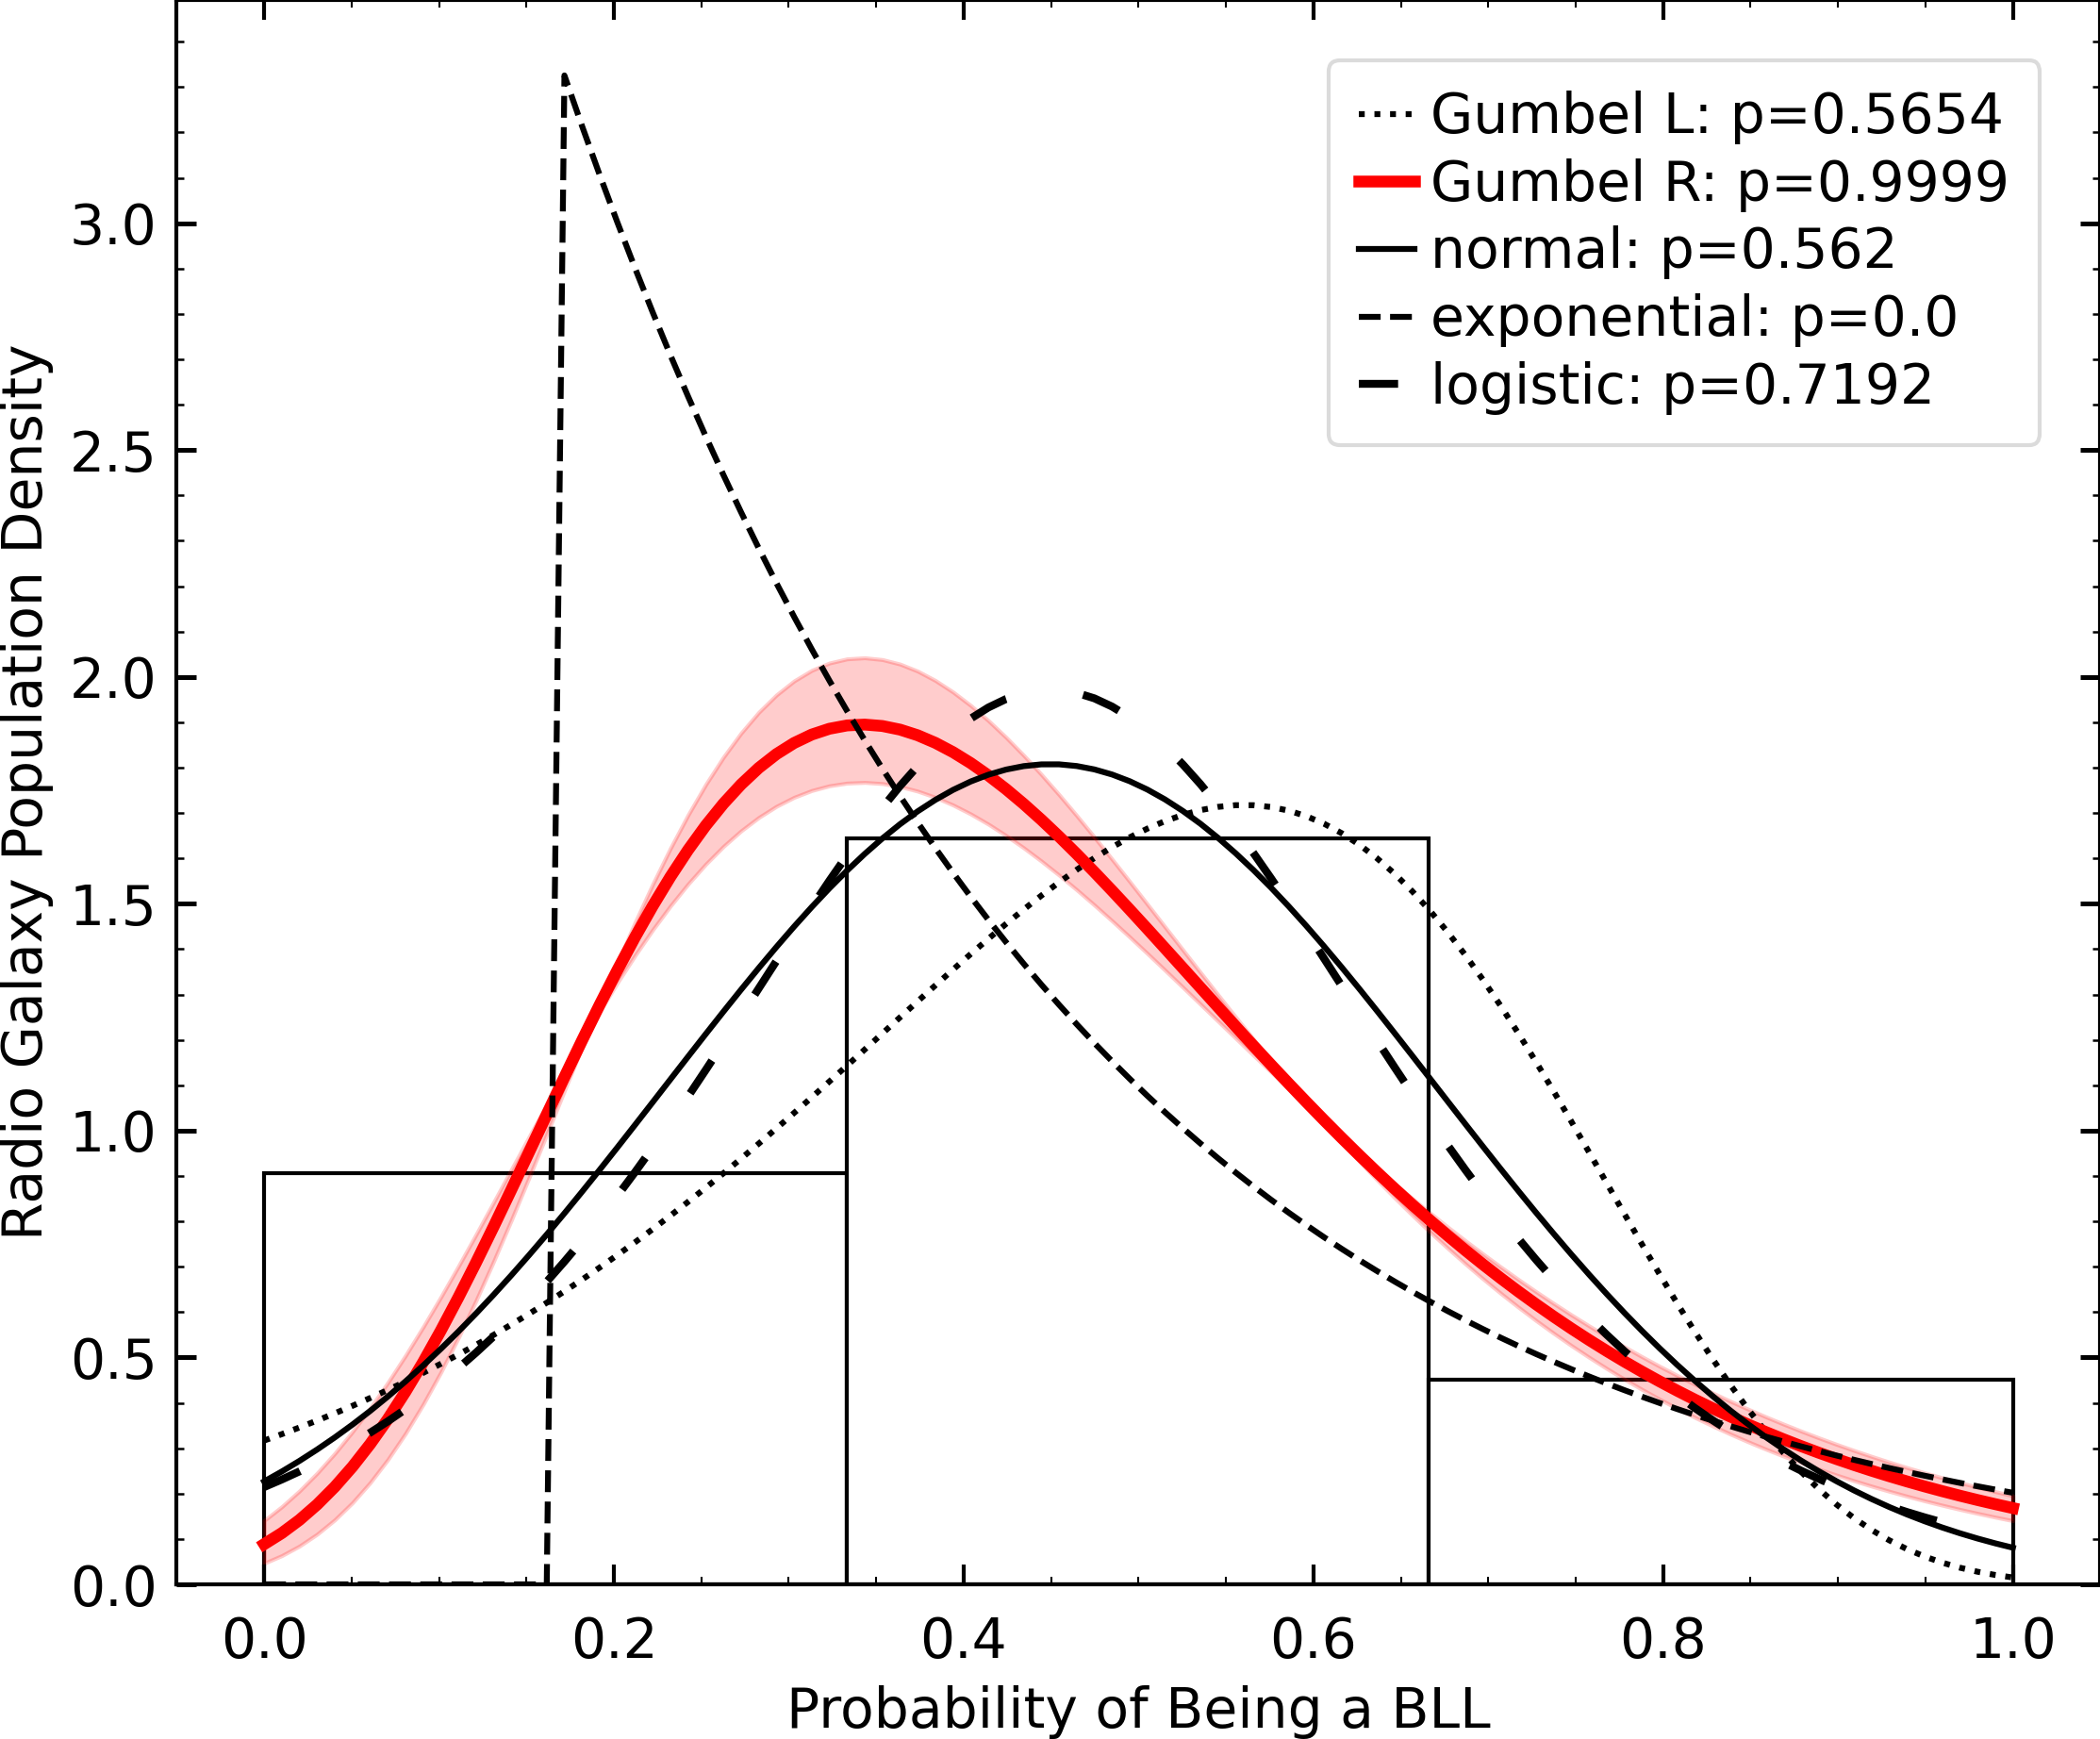

In [14]:
fig, ax = plt.subplots(figsize=(8,7),dpi=300)
ax.hist(dummydata,bins=[0,0.333,0.666,1],density=True,color='white',edgecolor='black',histtype='bar')

ax.plot(np.linspace(0,1,100),gumbel_l.pdf(np.linspace(0,1,100),loc=locgumbel_l,scale=scalegumbel_l),
        label='Gumbel L: p='+str(pgumbel_l),linestyle='dotted',color='black')
ax.plot(np.linspace(0,1,100),gumbel_r.pdf(np.linspace(0,1,100),loc=locgumbel_r,scale=scalegumbel_r),
        label='Gumbel R: p='+str(pgumbel_r),linestyle='solid',color='red',linewidth=3)
ax.fill_between(np.linspace(0,1,100),gumbel_r.pdf(np.linspace(0,1,100),
        loc=locgumbel_r,scale=scalegumbel_r+0.014),gumbel_r.pdf(np.linspace(0,1,100),
        loc=locgumbel_r,scale=scalegumbel_r-0.014),color='red',alpha=0.2,interpolate=False)


ax.plot(np.linspace(0,1,100),norm.pdf(np.linspace(0,1,100),loc=locnorm,scale=scalenorm),
        label='normal: p='+str(pnorm),linestyle='solid',color='black')
ax.plot(np.linspace(0,1,100),expon.pdf(np.linspace(0,1,100),loc=locexpon,scale=scaleexpon),
        label=f'exponential: p={pexpon:.4}',linestyle=('dashed'),color='black')
ax.plot(np.linspace(0,1,100),logistic.pdf(np.linspace(0,1,100),loc=loclogistic,scale=scalelogistic),
        label='logistic: p='+str(plogistic),color='black',linestyle=(0, (5, 10)),linewidth=2)



ax.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_xlabel('Probability of Being a BLL',fontsize=14)
ax.set_ylabel('Radio Galaxy Population Density',fontsize=14)

In [ ]:
# BOOTSTRAPPING

import string

# creating weights

bin1size=17
bin2size=25
bin3size=11

totsize=bin1size+bin2size+bin3size

bin1val=1/6
bin2val=1/2
bin3val=5/6

bin1weight = bin1size/totsize
bin2weight=bin2size/totsize
bin3weight=bin3size/totsize

elements=[bin1val,bin2val,bin3val]
weights=[bin1weight,bin2weight,bin3weight]

N=9999

loc=np.zeros(N)
scale=np.zeros(N)
for i in range(0,N):
    new_dummydata=np.random.choice(elements, 53, p=weights)
        
    fitresults = goodness_of_fit(gumbel_r,new_dummydata,statistic='ad',n_mc_samples=5)
    fit_params=str(fitresults[0])
    
    # converting strings to floats

    fit_params= [idx for idx in fit_params.split(' ')]
    fit_param_a=fit_params[3]
    fit_param_b=fit_params[4]
    fit_param_a= [idx for idx in fit_param_a.split('=')][1]
    fit_param_b= [idx for idx in fit_param_b.split('=')][1]
    fit_param_a=float(fit_param_a.replace(',',''))
    fit_param_b=float(fit_param_b.replace(')',''))
    loc[i]=fit_param_a
    scale[i]=fit_param_b

print(f'Loc: {np.average(loc)} +- {np.std(loc)}')
print(f'Scale: {np.average(scale)} +- {np.std(scale)}')


Loc: 0.34614595205003407 +- 0.030507174175566924
Scale: 0.20582825629004034 +- 0.013956085879593304
